<a href="https://colab.research.google.com/github/pablo-arantes/ParametrizANI/blob/main/ParametrizANI_OpenFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ParametrizANI: Fast, Accurate and Free Parametrization for Small Molecules**

We have found ourselves several times in a situation where we have to parametrize compounds for running Molecular Dynamics Simulations.
This Jupyter notebook provides a practical protocol to parametrize small molecules for OpenFF force fields using state-of-the-art reference methods such as [**TorchANI**](https://aiqm.github.io/torchani/), [**AIMNet2**](https://github.com/isayevlab/AIMNet2), [**MACE-OFF**](https://github.com/ACEsuit/mace) or [**GFN2-xTB**](https://github.com/grimme-lab/xtb)

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to parametrize compounds in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for parametrization!** It is just simple parametrization pipeline illustrating each step of a protocol.

---

**IMPORTANT**: Please set the runtime type to CPU. Using the GPU runtime may cause execution errors.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/ParametrizANI/issues

**Acknowledgments**
- We would like to express our gratitude to the team behind [Rotational Profiler](https://rotprof.lncc.br/index.php), especially [Victor H. Rusu](https://www.linkedin.com/in/victor-holanda-rusu-463766b2/) and [Roberto D. Lins](https://www.linkedin.com/in/roberto-lins-49477710/), for their dedication in developing the code and making it permanently available to the community.

- We would like to thank the OpenMM team for developing an excellent and open source engine.

- We would like to thank the [Psi4](https://psicode.org/) team for developing an excellent and open source suite of ab initio quantum chemistry.

- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).

- We would like to thank the [Olexandr Isayev](https://twitter.com/olexandr) team for developing the fantastic [AIMNet2](https://github.com/isayevlab/AIMNet2).

- We would like to thank the [Xavier Barril](http://www.ub.edu/bl/) team for their protocol on dihedrals parametrization.

- We would like to thank [iwatobipen](https://twitter.com/iwatobipen) for his fantastic [blog](https://iwatobipen.wordpress.com/) on chemoinformatics.

- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.

- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.

- For related notebooks see: https://github.com/pablo-arantes/ParametrizANI

# **Workflow for dihedral parametrization:**
An end-to-end pipeline integrating neural network potentials and molecular mechanics:

The workflow starts from a SMILES string and proceeds through the following steps:
1.	**Conformer generation**;
2.	**Reference energy calculations** using TorchANI, AIMNet2, MACE-OFF, or GFN2-xTB;
3.	**Energy minimization** with OpenMM;
4.	**Dihedral parameter optimizatio**n via least-squares fitting to reproduce the reference energy profile;
5.	**Validation**, and,
6.	**Generation of final topology and parameter** files for use in molecular simulations.

<img src="https://github.com/pablo-arantes/ParametrizANI//raw/main/flux.png" width="400" height="HEIGHT">

# **Setting the environment for the calculation**

Firstly, we need to install all necessary libraries and packages for our protocol. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org/)
3.    RDKit (https://www.rdkit.org/)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    TorchANI (https://aiqm.github.io/torchani/)

In [1]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
# !pip install -q condacolab
# import condacolab
# condacolab.install()

!pip install -q condacolab
import condacolab
condacolab.install_from_url("https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh")

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
#@title **Install MACE-OFF dependencies**
#@markdown This step may take a few minutes.
#@markdown Please run this cell to install the required Torch dependencies and MACE-OFF.
# install dependencies
import subprocess
import sys
subprocess.run("pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118", shell=True)
subprocess.run("pip install e3nn==0.4.4 opt_einsum ase torch_ema prettytable", shell=True)
subprocess.run("git clone https://github.com/ACEsuit/mace.git", shell=True)
subprocess.run("pip install ./mace", shell=True)
subprocess.run("pip install -U numpy==1.26.4", shell=True)
from mace.calculators import mace_off

/usr/local/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [2]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
import subprocess
import sys
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("pip install ase", shell=True)
subprocess.run("mamba install openmm", shell=True)
subprocess.run("mamba install -c conda-forge rdkit -y", shell=True)
subprocess.run("mamba install -c conda-forge openbabel -y", shell=True)
subprocess.run("pip install pymol-open-source", shell=True)
subprocess.run("pip uninstall torch -y", shell=True)
subprocess.run("mamba install openmmforcefields -c conda-forge -y", shell=True)
subprocess.run("pip install torchani", shell=True)
subprocess.run("conda install -c conda-forge xtb-python -y", shell=True)
subprocess.run("git clone https://github.com/pablo-arantes/AIMNet2.git", shell=True)

CompletedProcess(args='git clone https://github.com/pablo-arantes/AIMNet2.git', returncode=0)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Smiles: C1=CC=C(C=C1)/C=C/C(=O)C2=CC=CC=C2


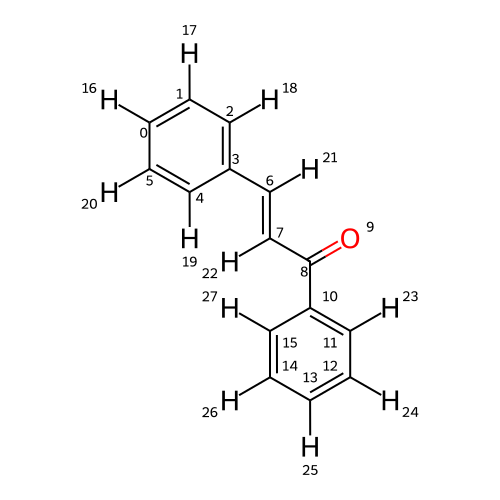

In [3]:
#@title **Please Provide the Required Information for Your Molecule**

#@markdown Enter the SMILES string or filename of your molecule (supported formats: PDB or MOL).
#@markdown **Examples:** `C=CC(=O)OC`, `molecule.pdb`, or `molecule.mol`.

#@markdown If you want to use a PDB or MOL file, please make sure to upload the file to this Colab session first.

#@markdown If you are unsure of the exact SMILES notation, you can search for it at [PubChem](https://pubchem.ncbi.nlm.nih.gov/).

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import rdForceFieldHelpers
from rdkit.Chem import rdmolfiles
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from openbabel import pybel
import py3Dmol

import os

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

import py3Dmol


Type = "smiles" #@param ["smiles", "pdb", "mol"]

smiles_or_filename = 'C1=CC=C(C=C1)/C=C/C(=O)C2=CC=CC=C2' #@param {type:"string"}
workDir = "/content/"

if Type == "smiles":
  Smiles = smiles_or_filename
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  hmol2D = Chem.AddHs(smiles_fig)

  # AllChem.EmbedMolecule(hmol)
  # AllChem.UFFOptimizeMolecule(hmol)
  # pdb_block = Chem.MolToPDBBlock(hmol)
  # with open('ini.pdb', 'w') as file:
  #   file.write(pdb_block)
elif Type == "pdb":
  mol= [m for m in pybel.readfile(filename=smiles_or_filename, format='pdb')][0]
  out=pybel.Outputfile(filename='mol.mol',format='mol',overwrite=True)
  out.write(mol)
  out.close()
  mol = Chem.MolFromMolFile('mol.mol')
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
else:
  mol = Chem.MolFromMolFile(smiles_or_filename)
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)

original_stdout = sys.stdout # Save a reference to the original standard output
final_smiles = '/content/smiles.smi'
with open(final_smiles, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(Smiles, ' ')
    sys.stdout = original_stdout



mol = Chem.MolFromSmiles(Smiles)
new_match = hmol.GetSubstructMatch(mol)
hmol = Chem.AddHs(mol)
AllChem.EmbedMolecule(hmol)
mp = rdForceFieldHelpers.MMFFGetMoleculeProperties(hmol)
ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(hmol, mp)
AllChem.OptimizeMolecule(ff, maxIters=200)
ff.Minimize()
AllChem.MolToMolFile(hmol, (os.path.join(workDir, "smiles_min.mol")))
AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "smiles_min.pdb")))

# Function to extract atom information from PDB file
def extract_atom_info_from_pdb(pdb_file_path):
    atom_info = []
    with open(pdb_file_path, 'r') as f:
        for line in f:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                atom_number = int(line[6:11].strip())
                atom_name = line[12:16].strip()
                element = line[76:78].strip()
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                atom_info.append((atom_number-1, atom_name, element, x, y, z))
    return atom_info

# Read atom information from PDB file
pdb_file_path = os.path.join(workDir, "smiles_min.pdb")  # Replace with your actual PDB file path
atom_info = extract_atom_info_from_pdb(pdb_file_path)

# Initialize Py3Dmol view
view = py3Dmol.view(width=800, height=600)

# Load the PDB file to Py3Dmol
with open(pdb_file_path, 'r') as f:
    pdb_data = f.read()
view.addModel(pdb_data,'pdb', {'keepH':'true'})

# Add stick representation
view.setStyle({'model': -1}, {'stick': {'radius': 0.15}, 'sphere': {'radius': 0.5}})

# Add labels for atom numbers and names, skipping hydrogens
for atom_number, atom_name, element, x, y, z in atom_info:
    # if element != 'H':
        # label = f"{atom_name} ({atom_number})"
        label = f"{atom_number}"

        view.addLabel(label, {"position": {"x": x, "y": y, "z": z}, "fontColor": "white", "backgroundColor": "transparent", "fontSize": 14})

# Additional configurations
view.setBackgroundColor("white")
view.zoomTo()

# Show the view
view.show()

d2d = rdMolDraw2D.MolDraw2DSVG(500, 500)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(hmol2D)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
with open('smiles.svg', 'w') as f:
    f.write(svg)
print("Smiles: " + str(Smiles))
SVG(svg)

In [4]:
#@title ### **Set Your Dihedral Angle**
#@markdown Specify the indices of the four atoms that define the dihedral angle to be parametrized.

#@markdown The selected atoms will be used to calculate and fit the dihedral energy profile.

#@markdown The order of the atoms should follow: atom1 - atom2 - atom3 - atom4, where atom2–atom3 is the rotatable bond.

#@markdown 📌 *Example:* `[2, 5, 6, 8]` means you are analyzing the dihedral defined by atoms 2-5-6-8.


from termcolor import colored
from rdkit.Chem import rdForceFieldHelpers
from rdkit.Chem import rdmolfiles
from openbabel import openbabel as ob
import numpy as np
atom1 = '6' #@param {type:"string"}
atom2 = '7' #@param {type:"string"}
atom3 = '8' #@param {type:"string"}
atom4 = '9' #@param {type:"string"}

# degrees_steps = "30" #@param ["5","10", "15", "20", "30", "45", "60"]

sequencially_parametrization  = "no" #@param ["yes", "no"]
dihedral_ring = "no"
# dihedral_ring = "no" #@param ["yes", "no"]
#@markdown Select the step size (in degrees) for rotating the dihedral angle during the energy scan.
#@markdown A smaller step size provides higher resolution but increases computational cost.
degrees_steps = "30" #@param ["1", "2", "3", "4", "5","10", "15", "20", "30", "45", "60"]
with open('degrees.dat', 'w') as f:
  f.write(degrees_steps)
max_deg = 180 #@param {type:"slider", min:-180, max:180, step:10}
min_deg = -180 #@param {type:"slider", min:-180, max:180, step:10}

# optimization = "MMFF94" #@param ["ANI", "MMFF94"]
mol = Chem.MolFromSmiles(Smiles)
new_match = hmol.GetSubstructMatch(mol)
hmol = Chem.AddHs(mol)
AllChem.EmbedMolecule(hmol)
mp = rdForceFieldHelpers.MMFFGetMoleculeProperties(hmol)
ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(hmol, mp)
  # for atidx in new_match:
  #   ff.MMFFAddPositionConstraint(atidx,0.05,200)
  # maxIters = 10
  # while ff.Minimize(maxIts=1000) and maxIters>0:
  #   maxIters -= 1
AllChem.OptimizeMolecule(ff, maxIters=200)
ff.Minimize()
AllChem.MolToMolFile(hmol, (os.path.join(workDir, "smiles_min.mol")))
AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "smiles_min.pdb")))
# Convert RDKit molecule to Open Babel molecule
ob_mol = pybel.readstring("mol", Chem.MolToMolBlock(hmol))

# Write to MOL2 file
ob_mol.write("mol2", "smiles_min.mol2", overwrite=True)

charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
charges = Chem.GetFormalCharge(hmol)
print("Charge = " + str(charges))
# mol_end = mol_with_atom_index(hmol)
# IPythonConsole.drawMol3D(hmol)


# Function to extract atom information from PDB file
def extract_atom_info_from_pdb(pdb_file_path):
    atom_info = []
    with open(pdb_file_path, 'r') as f:
        for line in f:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                atom_number = int(line[6:11].strip())
                atom_name = line[12:16].strip()
                element = line[76:78].strip()
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                atom_info.append((atom_number-1, atom_name, element, x, y, z))
    return atom_info

selected_atoms = [int(atom) for atom in [atom1, atom2, atom3, atom4]]

# Read atom information from PDB file
pdb_file_path = os.path.join(workDir, "smiles_min.pdb")  # Replace with your actual PDB file path
atom_info = extract_atom_info_from_pdb(pdb_file_path)

# Initialize Py3Dmol view
view = py3Dmol.view(width=800, height=600)

# Load the PDB file to Py3Dmol
with open(pdb_file_path, 'r') as f:
    pdb_data = f.read()
# view.addModel(pdb_data, format='pdb', {'keepH':'true'})
view.addModel(pdb_data,'pdb', {'keepH':'true'})

# Add stick representation
view.setStyle({'model': -1}, {'stick': {'radius': 0.15}, 'sphere': {'radius': 0.5}})
print("Selected atoms:")
# Add labels for atom numbers and names, skipping hydrogens
for atom_number, atom_name, element, x, y, z in atom_info:
  if atom_number in selected_atoms:
        # label = f"{atom_name} ({atom_number})"
        label = f"{atom_number}"
        view.addLabel(label, {"position": {"x": x, "y": y, "z": z}, "fontColor": "white", "backgroundColor": "transparent", "fontSize": 14})

# Additional configurations
view.setBackgroundColor("white")
view.zoomTo()

# Show the view
view.show()

Charge = 0
Selected atoms:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
#@title ### **Generate Conformers Based on the Selected Dihedral Angle**
#@markdown Run this cell to generate conformers by rotating the selected dihedral angle.
#@markdown The dihedral will be systematically rotated from -180° to 180°, using the step size defined in the previous cell.


#Create the conformers and save in the folder
import glob
import copy
import numpy as np
from IPython.display import display

if os.path.exists(os.path.join(workDir, "mol_files")):
  for f in glob.glob(os.path.join(workDir, "mol_files/*.mol")):
    os.remove(f)
else:
  os.mkdir(os.path.join(workDir, "mol_files"))

confs = []
filenames = []


# if optimization == "ANI":
#   hmol = AllChem.MolFromMolFile ((os.path.join(workDir, f"start_min.mol")), removeHs=False)
# else:
#   pass

for deg in range(min_deg, (max_deg+int(degrees_steps)), int(degrees_steps)):
    rdMolTransforms.SetDihedralDeg(hmol.GetConformer(0), int(atom1), int(atom2), int(atom3), int(atom4), deg)
    mp = rdForceFieldHelpers.MMFFGetMoleculeProperties(hmol)
    ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(hmol, mp)
    ff.MMFFAddTorsionConstraint(int(atom1), int(atom2), int(atom3), int(atom4), False, deg, deg, 1000.0,)
    # for atidx in new_match:
    #   ff.MMFFAddPositionConstraint(atidx,0.05,200)
    # maxIters = 10
    # while ff.Minimize(maxIts=500) and maxIters>0:
    #   maxIters -=1
    AllChem.OptimizeMolecule(ff, maxIters=200)
    ff.Minimize(maxIts=1000)
    AllChem.MolToMolFile(hmol, (os.path.join(workDir, "mol_files/" + str(deg) + ".mol")))
    # if deg % 90 == 0:
    #     print(deg)
        # display(IPythonConsole.drawMol3D(hmol))

In [6]:
#@title **Calculate reference energy profile using TorchANI, AIMNet2, MACE-OFF or GFN2-xTB**:


#@markdown Optimization and energy calculation of each conformer, using **TorchANI**, **AIMNet2**, **MACE-OFF** or **GFN2-xTB** as the optimizing engine.
#@markdown TorchANI, AIMNet2, MACE-OFF or GFN2-xTB will be used to obtain the energy profile of the dihedral angle that will act as a reference.

#@markdown ANI is a general-purpose neural network-based atomistic potential for organic molecules. Four ANI models have been published, the ANI-1, ANI-1x, ANI-1ccx, and ANI-2x potentials. The ANI-1 model was developed by random sampling conformational space of 57k organic molecules with up to eight heavy atoms, C, N, and O, plus H atoms to have proper chemistry, then running DFT calculations to obtain potential energies for training. ANI-1x was trained to a data set of molecular conformations sampled through an active learning scheme. Active learning is where the model itself is iteratively used to decide what new data should be included in the next iteration. ANI-1ccx was trained to the ANI-1x data set, then retrained to a 10% smaller data set of accurate coupled cluster calculations, resulting in a potential that outperformed DFT in test cases. ANI-2x was trained by adding many millions of data points to the ANI-1x data set, at the same level of theory, but including elements S, F, and Cl. We included the **ANI-1x**, **ANI-1ccx**, and **ANI-2x** models in our notebook.

#@markdown We have now integrated TorchANI2 into our pipeline, along with the latest improved ANI models trained on the expanded 2× dataset (**ANI-2xr, ANI-2dr, ANI-2xr-Snn, and ANI-mbis**). These models were trained at the B97-3c level of theory and include explicit repulsion and dispersion corrections, smoother potential energy surfaces (PES), and MBIS-derived charges.

#@markdown TorchANI will calculate a reliability index, which here is called **RHO**. We set a threshold of 0.6 kcal/mol such that if RHO < 0.6 everything is fine, if RHO > 0.6 be careful and if RHO > 1, the values cannot be used for the fitting. The ouput will show a flag in the cases where we have an issue.

#@markdown If you want to know more about **TorchANI**, please, check at https://aiqm.github.io/torchani/

#@markdown The AIMNet2 (a general-purpose neural netrork potential for organic and element-organic molecules) models are applicable for systems containing the following set of chemical elements: H, B, C, N, O, F, Si, P, S, Cl, As, Se, Br, I, both neutral and charged. The models aim to reproduce RKS B97-3c and wB97M-D3 energies.

#@markdown If you want to know more about **AIMNet2**, please, check at https://github.com/isayevlab/AIMNet2

#@markdown MACE-OFF, a transferable bio-organic machine learning force fields, are parametrized for the 10 most important chemical elements for organic chemistry: H, C, N, O, F, P, S, Cl, Br, and I. They are capable of accurately describing intra- and intermolecular interactions of neutral, closed-shell systems. This enables the simulation of a wide range of chemical systems, from molecular liquids and crystals to drug-like molecules and biopolymers.

#@markdown **Note:** MACE-OFF tends to run slower than other models. For improved performance and stability, we recommend setting the convergence threshold to 0.1.

#@markdown If you want to know more about **MACE-OFF**, please, check at https://github.com/ACEsuit/mace

#@markdown GFN2-xTB is an extended semiempirical tight-binding model primarily designed for the fast calculation of structures and noncovalent interaction energies for molecular systems with roughly 1000 atoms, notably including anisotropic second-order density fluctuation effects via cumulative atomic multipole moments and a self-consistent D4 London dispersion model.

#@markdown If you want to know more about **GFN2-xTB**, please, check at https://github.com/grimme-lab/xtb

#@markdown 🔹 Tip: If you want to upload your own reference energy file, please ensure the values are in **kcal/mol** and select the option **`upload_reference_energy`**.

#@markdown You can find an example of the required file format [**here**](https://github.com/pablo-arantes/ParametrizANI/raw/main/examples/ani.dat).

#@markdown Please, select your model:
model_name = "ANI-2xr-Snn" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x", "ANI-2xr", "ANI-2dr", "ANI-2xr-Snn","ANI-mbis", "B97-3c", "wB97M-D3","MACE-OFF", "GFN2-xTB", "upload_reference_energy"]
optimization = "Yes" #["Yes", "No"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.01 #@param {type:"slider", min:0.0001, max:0.1, step:0.0001}


import os
import re
import torch
import numpy as np
from ase import Atoms
from ase.optimize import BFGS, LBFGS
from ase.io import read, write
from ase.constraints import FixInternals
from openbabel import pybel
from openbabel import openbabel
import torch
import torchani
from torchani.units import HARTREE_TO_KCALMOL
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Geometry import Point3D
from google.colab import files
import sys
import torch.nn.functional as F
import ase.calculators.calculator

class AIMNet2Calculator(ase.calculators.calculator.Calculator):
    """ ASE calculator for AIMNet2 model
    Arguments:
        model (:class:`torch.nn.Module`): AIMNet2 model
        charge (int or float): molecular charge.  Default: 0
    """

    implemented_properties = ['energy', 'forces', 'free_energy', 'charges']

    def __init__(self, model, charge=0):
        super().__init__()
        self.model = model
        self.charge = charge
        self.device = next(model.parameters()).device
        cutoff = max(v.item() for k, v in model.state_dict().items() if k.endswith('aev.rc_s'))
        self.cutoff = float(cutoff)
        self._t_numbers = None
        self._t_charge = None

    def do_reset(self):
        self._t_numbers = None
        self._t_charge = None
        self.charge = 0.0

    def set_charge(self, charge):
        self.charge = float(charge)

    def _make_input(self):
        coord = torch.as_tensor(self.atoms.positions).to(torch.float).to(self.device).unsqueeze(0)
        if self._t_numbers is None:
            self._t_numbers = torch.as_tensor(self.atoms.numbers).to(torch.long).to(self.device).unsqueeze(0)
            self._t_charge = torch.tensor([self.charge], dtype=torch.float, device=self.device)
        d = dict(coord=coord, numbers=self._t_numbers, charge=self._t_charge)
        return d

    def _eval_model(self, d, forces=True):
        prev = torch.is_grad_enabled()
        torch._C._set_grad_enabled(forces)
        if forces:
            d['coord'].requires_grad_(True)
        _out = self.model(d)
        ret = dict(energy=_out['energy'].item(), charges=_out['charges'].detach()[0].cpu().numpy())
        if forces:
            if 'forces' in _out:
                f = _out['forces'][0]
            else:
                f = - torch.autograd.grad(_out['energy'], d['coord'])[0][0]
            ret['forces'] = f.detach().cpu().numpy()
        torch._C._set_grad_enabled(prev)
        return ret

    def calculate(self, atoms=None, properties=['energy'],
                  system_changes=ase.calculators.calculator.all_changes):
        super().calculate(atoms, properties, system_changes)
        _in = self._make_input()
        do_forces = 'forces' in properties
        _out =  self._eval_model(_in, do_forces)

        self.results['energy'] = _out['energy']
        self.results['charges'] = _out['charges']
        if do_forces:
            self.results['forces'] = _out['forces']

# Define utility functions
def mol2arr(mols, device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates, requires_grad=True, device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species

def pybel2atoms(mol):
    coord = np.array([a.coords for a in mol.atoms])
    numbers = np.array([a.atomicnum for a in mol.atoms])
    atoms = Atoms(positions=coord, numbers=numbers)
    return atoms

def update_mol(mol, atoms, align=True):
    mol_old = pybel.Molecule(pybel.ob.OBMol(mol.OBMol))
    for i, c in enumerate(atoms.get_positions()):
        mol.OBMol.GetAtom(i+1).SetVector(*c.tolist())
    if align:
        aligner = pybel.ob.OBAlign(False, False)
        aligner.SetRefMol(mol_old.OBMol)
        aligner.SetTargetMol(mol.OBMol)
        aligner.Align()
        aligner.UpdateCoords(mol.OBMol)

def guess_pybel_type(filename):
    return os.path.splitext(filename)[1][1:]

def guess_charge(mol):
    m = re.search('charge: (-?\d+)', mol.title)
    return int(m.group(1)) if m else mol.charge

def convert_mol_to_xyz(mol_file_path, xyz_file_path):
    obConversion = openbabel.OBConversion()
    obConversion.SetInAndOutFormats("mol", "xyz")
    mol = openbabel.OBMol()
    obConversion.ReadFile(mol, mol_file_path)
    obConversion.WriteFile(mol, xyz_file_path)

def optimize(atoms, prec=1e-3, steps=1000, traj=None):
    with torch.jit.optimized_execution(False):
        opt = LBFGS(atoms, trajectory=traj)
        opt.run(prec, steps)

workDir = "/content"  # Define working directory

# Set device for TorchANI
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model selection and setup
if model_name in ["ANI-1x", "ANI-1ccx", "ANI-2x", "ANI-2xr", "ANI-2dr", "ANI-2xr-Snn","ANI-mbis"]:
    if model_name == "ANI-2x":
        model = torchani.models.ANI2x(periodic_table_index=True).to(device)
        calculator = torchani.models.ANI2x().ase()
    elif model_name == "ANI-1ccx":
        model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
        calculator = torchani.models.ANI1ccx().ase()
    elif model_name == "ANI-1x":
        model = torchani.models.ANI1x(periodic_table_index=True).to(device)
        calculator = torchani.models.ANI1x().ase()
    elif model_name == "ANI-mbis":
        model = torchani.models.ANImbis(periodic_table_index=True).to(device)
        calculator = torchani.models.ANImbis().ase()
    elif model_name == "ANI-2dr":
        model = torchani.models.ANI2dr(periodic_table_index=True).to(device)
        calculator = torchani.models.ANI2dr().ase()
    elif model_name == "ANI-2xr-Snn":
        model = torchani.models.SnnANI2xr(periodic_table_index=True).to(device)
        calculator = torchani.models.SnnANI2xr().ase()
    else:
        model = torchani.models.ANI2xr(periodic_table_index=True).to(device)
        calculator = torchani.models.ANI2xr().ase()
    print(f"Model = {model_name}")
elif model_name in ["B97-3c", "wB97M-D3"]:
    folder_path = '/content/AIMNet2/calculators/'
    sys.path.append(folder_path)
    if model_name == "wB97M-D3":
        model_file = '/content/AIMNet2/models/aimnet2_wb97m-d3_ens.jpt'
    else:
        model_file = '/content/AIMNet2/models/aimnet2_b973c_ens.jpt'
    print('Loading AIMNet2 model from file', model_file)
    model = torch.jit.load(model_file, map_location=device)
    calc = AIMNet2Calculator(model)
elif model_name in ["MACE-OFF"]:
    from mace.calculators import mace_off
    calc = mace_off(model="medium", device=('cuda' if torch.cuda.is_available() else 'cpu'))
    print(f"Model = {model_name}")
elif model_name in ["GFN2-xTB"]:
    from xtb.ase.calculator import XTB
    calc = XTB(method="GFN2-xTB")
    print(f"Model = {model_name}")
elif model_name in ["upload_reference_energy"]:
    uploaded = files.upload()
    for fn in uploaded.keys():
      os.rename(fn, "QM.dat")

    dihe_degree = []
    for deg in range(min_deg, (max_deg + int(degrees_steps)), int(degrees_steps)):
      dihe_degree.append(deg)

    # Function to read .dat file and store values in a list
    def read_dat_file(file_path):
        with open(file_path, 'r') as file:
            values = [float(line.strip()) for line in file]
        return values

    # Path to your .dat file
    file_path = 'QM.dat'

    # Read and store values in a list
    values_list = read_dat_file(file_path)

    ref_energies = values_list
    print("Degrees    Energy")
    with open(f"QM_{atom1}_{atom2}_{atom3}_{atom4}.dat", 'w') as f:
        for deg, item in zip(dihe_degree, ref_energies):
            string = f"{deg:>8.3f} {item:>8.3f} kcal/mol"
            print(string)
    sys.exit() # Use sys.exit() to stop cell execution


mol_ext = ".mol"

energy_list = []
dihe_degree = []
qbc_list = []

for deg in range(min_deg, (max_deg + int(degrees_steps)), int(degrees_steps)):
    mol_file_path = os.path.join(workDir, "mol_files", f"{deg}{mol_ext}")
    mol_deg = AllChem.MolFromMolFile(mol_file_path, removeHs=False)

    if model_name in ["ANI-1x", "ANI-1ccx", "ANI-2x", "ANI-2xr", "ANI-2dr", "ANI-2xr-Snn", "ANI-mbis"]:
        coordinates, species = mol2arr([mol_deg], device)
        if optimization == "Yes":
            atoms = read(mol_file_path)
            tensor1 = coordinates.detach().numpy()
            atoms.set_positions(tensor1[0])
            dihedral_indices1 = [int(atom1), int(atom2), int(atom3), int(atom4)]
            dihedral1 = [atoms.get_dihedral(*dihedral_indices1), dihedral_indices1]
            c = FixInternals(dihedrals_deg=[dihedral1])
            atoms.set_constraint(c)
            atoms.set_calculator(calculator)
            opt = LBFGS(atoms)
            opt.run(fmax=opt_tol)
            write(os.path.join(workDir, "mol_files", f"{deg}_min.xyz"), format="xyz", images=atoms)

        # Conversion from XYZ to MOL and PDB
        atomic_symbols = []
        xyz_coordinates = []
        with open(os.path.join(workDir, "mol_files", f"{deg}_min.xyz"), "r") as file:
            for line_number, line in enumerate(file):
                if line_number == 0:
                    num_atoms = int(line)
                elif line_number == 1:
                    comment = line
                else:
                    atomic_symbol, x, y, z = line.split()
                    atomic_symbols.append(atomic_symbol)
                    xyz_coordinates.append([float(x), float(y), float(z)])

        conf = mol_deg.GetConformer()
        for i in range(mol_deg.GetNumAtoms()):
            x, y, z = xyz_coordinates[i]
            conf.SetAtomPosition(i, Point3D(x, y, z))
        AllChem.MolToMolFile(mol_deg, os.path.join(workDir, "mol_files", f"{deg}_min.mol"))
        AllChem.MolToPDBFile(mol_deg, os.path.join(workDir, "mol_files", f"{deg}_min.pdb"))

        mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "mol_files", f"{deg}_min.mol")), removeHs=False)
        coordinates, species = mol2arr([mol_deg], device)
        energy = model((species, coordinates)).energies
        energies_list = []
        for i in range(0,8,1):
          modeli = model[i]
          energyi = modeli((species, coordinates)).energies
          energies_list.append(energyi.item())
        qbc_factors = np.std(energies_list)
        num_atoms = (species >= 0).sum(dim=1)
        qbc_factors = (qbc_factors / num_atoms.sqrt()) * HARTREE_TO_KCALMOL
        qbc_list.append(qbc_factors.item())
        # derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
        # force = -derivative
        energy_list.append(energy.item())
        dihe_degree.append(deg)

    elif model_name in ["B97-3c", "wB97M-D3"]:
        xyz_file_path = os.path.join(workDir, "mol_files", f"{deg}.xyz")
        convert_mol_to_xyz(mol_file_path, xyz_file_path)
        out_file = os.path.join(workDir, "mol_files", f"{deg}_min.xyz")
        with open(out_file, 'w') as f:
            for mol in pybel.readfile(guess_pybel_type(xyz_file_path), xyz_file_path):
                atoms = pybel2atoms(mol)
                mol_charge = guess_charge(mol)
                calc.do_reset()
                calc.set_charge(mol_charge)
                dihedral_indices1 = [int(atom1), int(atom2), int(atom3), int(atom4)]
                dihedral1 = [atoms.get_dihedral(*dihedral_indices1), dihedral_indices1]
                c = FixInternals(dihedrals_deg=[dihedral1])
                atoms.set_constraint(c)
                atoms.set_calculator(calc)
                optimize(atoms, prec=opt_tol, steps=2000)
                energy = calc.get_potential_energy(atoms)
                energy_list.append(energy)
                dihe_degree.append(deg)
                update_mol(mol, atoms, align=False)
                f.write(mol.write(guess_pybel_type(out_file)))
                f.flush()

        # Conversion from XYZ to MOL and PDB
        atomic_symbols = []
        xyz_coordinates = []
        with open(os.path.join(workDir, "mol_files", f"{deg}_min.xyz"), "r") as file:
            for line_number, line in enumerate(file):
                if line_number == 0:
                    num_atoms = int(line)
                elif line_number == 1:
                    comment = line
                else:
                    atomic_symbol, x, y, z = line.split()
                    atomic_symbols.append(atomic_symbol)
                    xyz_coordinates.append([float(x), float(y), float(z)])

        conf = mol_deg.GetConformer()
        for i in range(mol_deg.GetNumAtoms()):
            x, y, z = xyz_coordinates[i]
            conf.SetAtomPosition(i, Point3D(x, y, z))
        AllChem.MolToMolFile(mol_deg, os.path.join(workDir, "mol_files", f"{deg}_min.mol"))
        AllChem.MolToPDBFile(mol_deg, os.path.join(workDir, "mol_files", f"{deg}_min.pdb"))
    elif model_name in ["MACE-OFF"]:
        coordinates, species = mol2arr([mol_deg], device)
        if optimization == "Yes":
            atoms = read(mol_file_path)
            tensor1 = coordinates.detach().numpy()
            atoms.set_positions(tensor1[0])
            dihedral_indices1 = [int(atom1), int(atom2), int(atom3), int(atom4)]
            dihedral1 = [atoms.get_dihedral(*dihedral_indices1), dihedral_indices1]
            c = FixInternals(dihedrals_deg=[dihedral1])
            atoms.set_constraint(c)
            atoms.set_calculator(calc)
            opt = LBFGS(atoms)
            opt.run(fmax=opt_tol)
            energy = calc.get_potential_energy(atoms)
            energy_list.append(energy)
            dihe_degree.append(deg)

            write(os.path.join(workDir, "mol_files", f"{deg}_min.xyz"), format="xyz", images=atoms)

        # Conversion from XYZ to MOL and PDB
        atomic_symbols = []
        xyz_coordinates = []
        with open(os.path.join(workDir, "mol_files", f"{deg}_min.xyz"), "r") as file:
            for line_number, line in enumerate(file):
                if line_number == 0:
                    num_atoms = int(line)
                elif line_number == 1:
                    comment = line
                else:
                    atomic_symbol, x, y, z = line.split()
                    atomic_symbols.append(atomic_symbol)
                    xyz_coordinates.append([float(x), float(y), float(z)])

        conf = mol_deg.GetConformer()
        for i in range(mol_deg.GetNumAtoms()):
            x, y, z = xyz_coordinates[i]
            conf.SetAtomPosition(i, Point3D(x, y, z))
        AllChem.MolToMolFile(mol_deg, os.path.join(workDir, "mol_files", f"{deg}_min.mol"))
        AllChem.MolToPDBFile(mol_deg, os.path.join(workDir, "mol_files", f"{deg}_min.pdb"))
    elif model_name in ["GFN2-xTB"]:
        coordinates, species = mol2arr([mol_deg], device)
        if optimization == "Yes":
            atoms = read(mol_file_path)
            tensor1 = coordinates.detach().numpy()
            atoms.set_positions(tensor1[0])
            dihedral_indices1 = [int(atom1), int(atom2), int(atom3), int(atom4)]
            dihedral1 = [atoms.get_dihedral(*dihedral_indices1), dihedral_indices1]
            c = FixInternals(dihedrals_deg=[dihedral1])
            atoms.set_constraint(c)
            atoms.set_calculator(calc)
            opt = LBFGS(atoms)
            opt.run(fmax=opt_tol)
            energy = calc.get_potential_energy(atoms)
            energy_list.append(energy)
            dihe_degree.append(deg)

            write(os.path.join(workDir, "mol_files", f"{deg}_min.xyz"), format="xyz", images=atoms)

        # Conversion from XYZ to MOL and PDB
        atomic_symbols = []
        xyz_coordinates = []
        with open(os.path.join(workDir, "mol_files", f"{deg}_min.xyz"), "r") as file:
            for line_number, line in enumerate(file):
                if line_number == 0:
                    num_atoms = int(line)
                elif line_number == 1:
                    comment = line
                else:
                    atomic_symbol, x, y, z = line.split()
                    atomic_symbols.append(atomic_symbol)
                    xyz_coordinates.append([float(x), float(y), float(z)])

        conf = mol_deg.GetConformer()
        for i in range(mol_deg.GetNumAtoms()):
            x, y, z = xyz_coordinates[i]
            conf.SetAtomPosition(i, Point3D(x, y, z))
        AllChem.MolToMolFile(mol_deg, os.path.join(workDir, "mol_files", f"{deg}_min.mol"))
        AllChem.MolToPDBFile(mol_deg, os.path.join(workDir, "mol_files", f"{deg}_min.pdb"))

# Calculate and print energies
if model_name in ["ANI-1x", "ANI-1ccx", "ANI-2x", "ANI-2xr", "ANI-2dr", "ANI-2xr-Snn", "ANI-mbis"]:
    ref_energies = (np.array(energy_list) - min(energy_list)) * HARTREE_TO_KCALMOL
    print("Degrees    Energy              RHO factor")
    with open(f"{model_name}_{atom1}_{atom2}_{atom3}_{atom4}.dat", 'w') as f:
        for deg, item, item2 in zip(dihe_degree, ref_energies, qbc_list):
            string = f"{deg:>8.3f} {item:>8.3f} kcal/mol   |  {item2:<8.3f} kcal/mol"
            if item2 >= 0.6 and item2 < 1:
                print(f"{string} WARNING:Check the plot!")
            elif item2 >= 1:
                print(f"{string} WARNING:Do not use this value for the fitting!")
            else:
                print(string)
            f.write(f"{item}\n")
elif model_name in ["B97-3c", "wB97M-D3"]:
    ref_energies = (np.array(energy_list) - min(energy_list)) * 23.0609
    print("Degrees    Energy")
    with open(f"{model_name}_{atom1}_{atom2}_{atom3}_{atom4}.dat", 'w') as f:
        for deg, item in zip(dihe_degree, ref_energies):
            string = f"{deg:>8.3f} {item:>8.3f} kcal/mol"
            print(string)
            f.write(f"{item}\n")
elif model_name in ["MACE-OFF"]:
    ref_energies = (np.array(energy_list) - min(energy_list)) * 23.0609
    print("Degrees    Energy")
    with open(f"{model_name}_{atom1}_{atom2}_{atom3}_{atom4}.dat", 'w') as f:
        for deg, item in zip(dihe_degree, ref_energies):
            string = f"{deg:>8.3f} {item:>8.3f} kcal/mol"
            print(string)
            f.write(f"{item}\n")
elif model_name in ["GFN2-xTB"]:
    ref_energies = (np.array(energy_list) - min(energy_list)) * 23.0609
    print("Degrees    Energy")
    with open(f"{model_name}_{atom1}_{atom2}_{atom3}_{atom4}.dat", 'w') as f:
        for deg, item in zip(dihe_degree, ref_energies):
            string = f"{deg:>8.3f} {item:>8.3f} kcal/mol"
            print(string)
            f.write(f"{item}\n")

<>:160: SyntaxWarning: invalid escape sequence '\d'
<>:160: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1955378351.py:160: SyntaxWarning: invalid escape sequence '\d'
  m = re.search('charge: (-?\d+)', mol.title)
/usr/local/lib/python3.12/site-packages/torchani/csrc/__init__.py:56: UserWarning: The extensions: ['cuaev', 'mnp', 'cell_list'] are not installed and will not be available. To install the extensions first install the CUDA Toolkit, and afterwards  run `ani build-extensions` To suppress warn set the env var TORCHANI_NO_WARN_EXTENSIONS=1 For example, if using bash, you may add `export TORCHANI_NO_WARN_EXTENSIONS=1` to your .bashrc
  warnings.warn(
/usr/local/lib/python3.12/site-packages/torchani/models.py:448: UserWarning: ANI-2xr-snn is experimental and hasn't yet been peer yet reviewed. It is subject to change in the near future
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` doe

snn-ani2xr.pt:   0%|          | 0.00/24.1M [00:00<?, ?B/s]

Model = ANI-2xr-Snn


/tmp/ipython-input-1955378351.py:272: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(calculator)


       Step     Time          Energy          fmax
LBFGS:    0 13:47:03   -17792.130859        1.249741
LBFGS:    1 13:47:03   -17792.144531        1.192754
LBFGS:    2 13:47:03   -17792.158203        0.290668
LBFGS:    3 13:47:03   -17792.164062        0.204557
LBFGS:    4 13:47:04   -17792.167969        0.204813
LBFGS:    5 13:47:04   -17792.173828        0.197372
LBFGS:    6 13:47:04   -17792.177734        0.161171
LBFGS:    7 13:47:04   -17792.179688        0.112355
LBFGS:    8 13:47:04   -17792.181641        0.116640
LBFGS:    9 13:47:04   -17792.183594        0.084492
LBFGS:   10 13:47:04   -17792.185547        0.079103
LBFGS:   11 13:47:05   -17792.187500        0.068753
LBFGS:   12 13:47:05   -17792.189453        0.077320
LBFGS:   13 13:47:05   -17792.191406        0.078942
LBFGS:   14 13:47:05   -17792.191406        0.078332
LBFGS:   15 13:47:05   -17792.191406        0.067444
LBFGS:   16 13:47:06   -17792.193359        0.065343
LBFGS:   17 13:47:06   -17792.193359        0.07

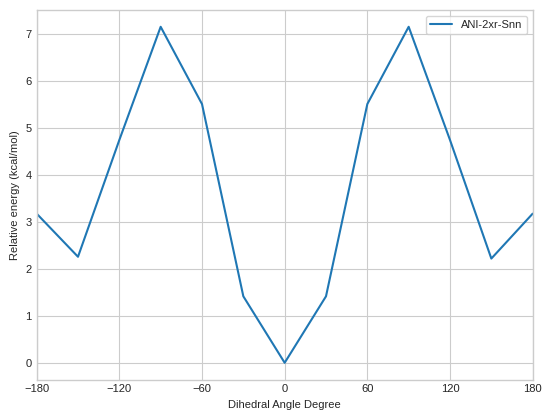

In [7]:
#@title **Visualize the Reference Energy Profile**

#@markdown This plot shows the reference energy profile used for dihedral parametrization.

#@markdown The **y-axis** represents the energy in *kcal/mol*, and the **x-axis** corresponds to the dihedral angle in degrees.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
plt.plot(dihe_degree, ref_energies, linewidth = 1.5, label = model_name)
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([min_deg, max_deg])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
png_name = f"{model_name}_{atom1}_{atom2}_{atom3}_{atom4}.png"
plt.savefig(png_name, dpi=600, bbox_inches='tight')

In [8]:
#@title **OpenMM Minimization with Dihedral Potential Set to Zero**

#@markdown Choose how to handle the dihedral potential during energy minimization of the conformers:

#@markdown - **Set to 0**: Minimizes the conformers **excluding the dihedral energy term** (only for the selected dihedral). This option considers only Van der Waals and electrostatic interactions and is recommended when you want to **parametrize a new dihedral potential** from scratch.

#@markdown - **Set to Default**: Minimizes the conformers using the **original dihedral parameters** from the selected force field. Use this option to **evaluate how well the force field describes** the selected dihedral angle.

#@markdown **Parameters to generate the molecule topology:**

Force_field = "openff-2.0.0" #@param ['smirnoff99Frosst-1.1.0', 'smirnoff99Frosst-1.0.0', 'smirnoff99Frosst-1.0.9', 'smirnoff99Frosst-1.0.1', 'smirnoff99Frosst-1.0.6', 'smirnoff99Frosst-1.0.5', 'smirnoff99Frosst-1.0.7', 'smirnoff99Frosst-1.0.8', 'smirnoff99Frosst-1.0.2', 'smirnoff99Frosst-1.0.4', 'smirnoff99Frosst-1.0.3', 'openff-1.0.0-RC1', 'openff-1.0.1', 'openff-1.3.1-alpha.1', 'openff-1.0.0', 'openff-1.2.0', 'openff-2.0.0-rc.2', 'openff-2.0.0-rc.1', 'openff-2.0.0', 'openff-1.1.0', 'openff-1.3.1', 'openff-1.1.1', 'openff-1.0.0-RC2', 'openff-1.3.0', 'openff-1.2.1']
Dihedral_potential_energy = "0" #@param ['0', 'Default']

#@markdown Force constant to restrain the dihedral angle:

Force_constant = 1000 #@param {type:"slider", min:100, max:2000, step:100}


#@markdown Convergence threshold for minimization energy:

opt_tol = 0.001 #@param {type:"slider", min:0.001, max:0.1, step:0.001}

import warnings
warnings.filterwarnings("ignore")
# from mdtraj.geometry import dihedral
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
# Imports from the toolkit
import openff.toolkit
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
from simtk.openmm.app import PDBFile
from openmmforcefields.generators import SMIRNOFFTemplateGenerator
from openmmforcefields.generators import GAFFTemplateGenerator

import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch


workDir2 = "/content/"

if os.path.exists(os.path.join(workDir2, "potential_energy.txt")):
  for f in glob.glob(os.path.join(workDir2, "pdb_min/*.pdb")):
    os.remove(f)
  os.remove(os.path.join(workDir2,"potential_energy.txt"))
else:
  if os.path.exists(os.path.join(workDir2, "pdb_min")):
    for f in glob.glob(os.path.join(workDir2, "pdb_min/*.pdb")):
      os.remove(f)
    os.rmdir(os.path.join(workDir2, "pdb_min"))
    os.mkdir(os.path.join(workDir2, "pdb_min"))
  else:
    os.mkdir(os.path.join(workDir2, "pdb_min"))


# Create an OpenFF Molecule object for benzene from sdf
from openff.toolkit.topology import Molecule
molecule = Molecule.from_smiles(Smiles)
# molecule = Molecule.from_file("/content/mol_files/0_min.mol")

small_ff_options = ['smirnoff99Frosst-1.1.0', 'smirnoff99Frosst-1.0.0', 'smirnoff99Frosst-1.0.9', 'smirnoff99Frosst-1.0.1',
            'smirnoff99Frosst-1.0.6', 'smirnoff99Frosst-1.0.5', 'smirnoff99Frosst-1.0.7', 'smirnoff99Frosst-1.0.8', 'smirnoff99Frosst-1.0.2', 'smirnoff99Frosst-1.0.4',
            'smirnoff99Frosst-1.0.3', 'openff-1.0.0-RC1', 'openff-1.0.1', 'openff-1.3.1-alpha.1', 'openff-1.0.0', 'openff-1.2.0', 'openff-2.0.0-rc.2', 'openff-2.0.0-rc.1',
            'openff-2.0.0', 'openff-1.1.0', 'openff-1.3.1', 'openff-1.1.1', 'openff-1.0.0-RC2', 'openff-1.3.0', 'openff-1.2.1']

type_generator_options = ('SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF',
                          'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF')

small_ff_include = ["'smirnoff99Frosst-1.1.0'", "'smirnoff99Frosst-1.0.0'", "'smirnoff99Frosst-1.0.9'", "'smirnoff99Frosst-1.0.1'",
            "'smirnoff99Frosst-1.0.6'", "'smirnoff99Frosst-1.0.5'", "'smirnoff99Frosst-1.0.7'", "'smirnoff99Frosst-1.0.8'", "'smirnoff99Frosst-1.0.2'", "'smirnoff99Frosst-1.0.4'",
            "'smirnoff99Frosst-1.0.3'", "'openff-1.0.0-RC1'", "'openff-1.0.1'", "'openff-1.3.1-alpha.1'", "'openff-1.0.0'", "'openff-1.2.0'", "'openff-2.0.0-rc.2'", "'openff-2.0.0-rc.1'",
            "'openff-2.0.0'", "'openff-1.1.0'", "'openff-1.3.1'", "'openff-1.1.1'", "'openff-1.0.0-RC2'", "'openff-1.3.0'", "'openff-1.2.1'"]


small_ff_id = small_ff_options.index(Force_field)
type_generator = type_generator_options[small_ff_id]
small_ff = small_ff_include[small_ff_id]

# Teach OpenMM about the ligand molecule and force field
ligand_generator = type_generator + "TemplateGenerator(forcefield=" + small_ff + ", molecules=[molecule])"
type_generator_options = eval(ligand_generator)


# Create an OpenMM ForceField object with AMBER ff14SB and TIP3P with compatible ions
from simtk.openmm.app import ForceField
forcefield = ForceField('amber99sb.xml')

# Register the  template generator
forcefield.registerTemplateGenerator(type_generator_options.generator)

potential_energy = []
dihe_degree = []
for deg in range(min_deg, (max_deg+int(degrees_steps)), int(degrees_steps)):
  pdbfile = PDBFile(os.path.join(workDir, "mol_files/" + str(deg) + "_min.pdb"))

  if sequencially_parametrization == "yes":
    with open(os.path.join(workDir, 'system_openMM.xml')) as input:
        system = XmlSerializer.deserialize(input.read())
  else:
    system = forcefield.createSystem(pdbfile.topology, nonbondedCutoff=1*nanometer, constraints=HBonds)

  for i, f in enumerate(system.getForces()):
    f.setForceGroup(i)


  energy_expression = "k*(1-cos(periodicity*theta-theta0))"
  custom_torsion_force = CustomTorsionForce(energy_expression)
  custom_torsion_force.addGlobalParameter("k", int(Force_constant))
  custom_torsion_force.addGlobalParameter("periodicity", 1)
  custom_torsion_force.addGlobalParameter("theta0", math.radians(deg))
  custom_torsion_force.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4))
  system.addForce(custom_torsion_force)

  integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
  simulation = Simulation(pdbfile.topology, system, integrator)
  simulation.context.setPositions(pdbfile.positions)

  if Dihedral_potential_energy == "0":
    dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
    for i in range(dih.getNumTorsions()):
      particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)
      if particle2 == int(atom2) and particle3 == int(atom3):
        # print(dih.getTorsionParameters(i))
        dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
        dih.updateParametersInContext(simulation.context)
        # print(dih.getTorsionParameters(i))
      elif particle2 == int(atom3) and particle3 == int(atom2):
        # print(dih.getTorsionParameters(i))
        dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
        dih.updateParametersInContext(simulation.context)
        # print(dih.getTorsionParameters(i))
      else:
        pass
  else:
    pass

  simulation.minimizeEnergy(tolerance=float(opt_tol)*kilojoule/(mole*nanometer), maxIterations=int(1000000))
  minpositions = simulation.context.getState(getPositions=True).getPositions()
  app.PDBFile.writeFile(pdbfile.topology, minpositions, open(os.path.join(workDir2, "pdb_min/" + str(deg) + '_min.pdb'), 'w'))

  energy_kcal =  (simulation.context.getState(getEnergy=True).getPotentialEnergy())
  potential_energy.append(energy_kcal)
  dihe_degree.append(deg)
  for i, f in enumerate(system.getForces()):
    state = simulation.context.getState(getEnergy=True, groups={i})
    # print(f.getName(), state.getPotentialEnergy())
  # print(str(deg) + " =", str(energy_kcal))
  print("Running minimization for step:" + str(deg))
  print(str(energy_kcal), file=open("potential_energy.txt", "a",))

#Prepare the relative energy from MM
import pandas as pd
dataset = pd.read_csv('/content/potential_energy.txt', delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df[df.columns[:1]]
new = df.to_numpy()
energy_diff = (np.array(new) - min(new)) * 0.239006
# print(np.round(energy_diff, 4))

print("Degrees    Energy")
#save a dat file
energy_mm = np.round(energy_diff, 4)
a_file = open(f"{Force_field}_{atom1}_{atom2}_{atom3}_{atom4}.dat", "w")
for deg, row in zip(dihe_degree, energy_mm):
    degree_str = str("{:.3f}".format(deg))
    energy_mm_str = str("{:.3f}".format(row[0]))
    string = degree_str.rjust(8, " ") + energy_mm_str.rjust(8, " ") + " kcal/mol"
    print(string)
    np.savetxt(a_file, row, fmt='%.6f')
a_file.close()

Running minimization for step:-180
Running minimization for step:-150
Running minimization for step:-120
Running minimization for step:-90
Running minimization for step:-60
Running minimization for step:-30
Running minimization for step:0
Running minimization for step:30
Running minimization for step:60
Running minimization for step:90
Running minimization for step:120
Running minimization for step:150
Running minimization for step:180
Degrees    Energy
-180.000   5.295 kcal/mol
-150.000   2.145 kcal/mol
-120.000   0.321 kcal/mol
 -90.000   0.000 kcal/mol
 -60.000   0.409 kcal/mol
 -30.000   1.489 kcal/mol
   0.000   2.965 kcal/mol
  30.000   1.488 kcal/mol
  60.000   0.409 kcal/mol
  90.000   0.000 kcal/mol
 120.000   0.321 kcal/mol
 150.000   2.146 kcal/mol
 180.000   5.295 kcal/mol


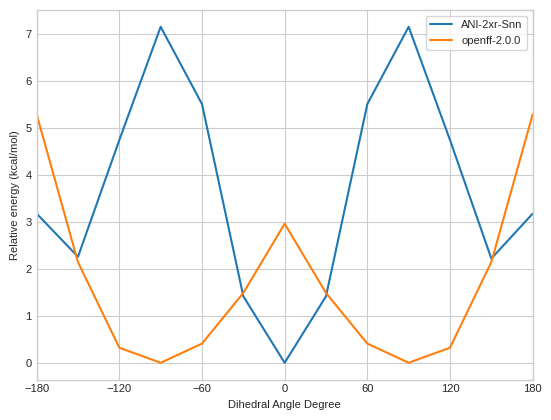

In [9]:
#@title **Visualize the Energy Profile Calculated with OpenMM**

#@markdown This plot shows the energy profile obtained using OpenMM.

#@markdown The **y-axis** represents the **relative energy** in *kcal/mol*, and the **x-axis** corresponds to the **dihedral angle** in degrees.

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
plt.plot(dihe_degree, ref_energies, linewidth = 1.5, label = model_name)
plt.plot(dihe_degree, energy_diff, linewidth = 1.5, label = Force_field)
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([min_deg, max_deg])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
png_name = f"{model_name}_{Force_field}_{atom1}_{atom2}_{atom3}_{atom4}.png"
plt.savefig(png_name, dpi=600, bbox_inches='tight')

In [10]:
#@title **Optimize Dihedral Parameters Based on Reference Energy Profile**

#@markdown This step fits an empirical energy profile to a reference profile (e.g., from TorchANI, AIMNet2, MACE-OFF, or GFN2-xTB).
#@markdown We use a Python implementation of the [Rotational Profiler](https://rotprof.lncc.br/index.php) (Rusu *et al.*), which provides an analytical algorithm for computing classical torsional parameters. The fitting uses a **linear least-squares regression** method to determine optimal parameters.

#@markdown The generated dihedral profiles are compatible with standard functional forms used in popular biomolecular force fields such as **GROMOS**, **AMBER**, **OPLS**, and **CHARMM**.

#@markdown Users can select the preferred fitting function to best reproduce the reference conformational energy landscape. Notably, **Rotational Profiler does not constrain the phase shift (δ) to 0° or 180°**, allowing for **asymmetric δ values**. While this improves the fit accuracy, it may reduce parameter transferability across stereoisomers.

import argparse
import logging
import os
import numpy as np

# dihe_degree_360 = [d + 180 for d in dihe_degree]


with open(f"{Force_field}_rotprof_{atom1}_{atom2}_{atom3}_{atom4}.dat", "w") as a_file:
    for deg, row in zip(dihe_degree, energy_diff):
        # Formatting the output string
        line = f"{deg:.3f} {row[0]:.3f}\n"

        # Writing the formatted string to the file
        a_file.write(line)

with open(f"{model_name}_rotprof_{atom1}_{atom2}_{atom3}_{atom4}.dat", "w") as a_file:
    for deg, row in zip(dihe_degree, ref_energies):
        # Formatting the output string
        line = f"{deg:.3f} {row:.3f}\n"

        # Writing the formatted string to the file
        a_file.write(line)

import argparse
import logging
import os
import numpy as np

# FileLogger class
class FileLogger:
    def __init__(self, file_name, mode='a'):
        self.file_name = file_name
        self.logger = logging.getLogger(__name__)
        self.set_up_file_logger(mode)

    def set_up_file_logger(self, mode):
        file_handler = logging.FileHandler(self.file_name, mode=mode)
        formatter = logging.Formatter('[%(levelname)s] %(message)s')
        file_handler.setFormatter(formatter)
        self.logger.addHandler(file_handler)

    def set_level(self, level):
        self.logger.setLevel(level)

    def debug(self, message, *args):
        self.logger.debug(message, *args)

    def info(self, message, *args):
        self.logger.info(message, *args)

    def warning(self, message, *args):
        self.logger.warning(message, *args)

    def error(self, message, *args):
        self.logger.error(message, *args)


# DataFileReader class
class DataFileReader:
    def __init__(self, file_name):
        self.file_name = file_name
        self.logger = logging.getLogger(__name__)

    def read_file(self):
        phis = []
        enes = []
        try:
            with open(self.file_name, 'r') as file:
                for line in file:
                    if line.startswith('#') or not line.strip():
                        continue  # Skip commented or empty lines
                    parts = line.split()
                    if len(parts) >= 2:
                        try:
                            phi = float(parts[0])
                            ene = float(parts[1])
                            phis.append(phi)
                            enes.append(ene)
                            self.logger.debug("data line: %s", line.strip())
                        except ValueError as e:
                            self.logger.error("Invalid data format: %s", e)
            if len(phis) == 0:
                self.logger.error("No data found inside data file %s", self.file_name)
                return [], []
            return phis, enes
        except IOError as e:
            self.logger.error("Error reading file %s: %s", self.file_name, e)
            return [], []

# IniFileReader class
class IniFileReader:
    def __init__(self, file_name):
        self.file_name = file_name
        self.logger = logging.getLogger(__name__)

    def read_file(self, N):
        is_active = [0] * N
        pshift = [0] * N
        multiplicities = [0] * N
        phase_offsets = [0.0] * N

        try:
            with open(self.file_name, 'r') as file:
                nlines = 0
                for line in file:
                    if line.startswith('#') or not line.strip():
                        continue  # Skip commented or empty lines
                    parts = line.split()
                    if len(parts) >= 4:
                        try:
                            multi = int(parts[0])
                            phi_shift = int(parts[1])
                            phase_offset = float(parts[2])
                            active = int(parts[3])

                            if nlines < N:
                                multiplicities[nlines] = multi
                                pshift[nlines] = phi_shift
                                phase_offsets[nlines] = phase_offset
                                is_active[nlines] = active
                                nlines += 1
                            else:
                                break  # Stop reading if N lines are read

                            self.logger.debug("ini line: %s", line.strip())
                        except ValueError as e:
                            self.logger.error("Invalid data format: %s", e)
            if nlines != N:
                self.logger.error(f"Expected {N} lines in file, found {nlines}")
                return [], [], [], []

            num_active_coeffs = sum(is_active)
            if num_active_coeffs < 1:
                self.logger.error("There are no active coefficients")
                return [], [], [], []

            return multiplicities, pshift, phase_offsets, is_active
        except IOError as e:
            self.logger.error("Error reading file %s: %s", self.file_name, e)
            return [], [], [], []


pi = 3.1415926535897932384626433832795028841971693993751058209749445923078164062862089986280348253421170679
SMALL_REAL = 1.0E-8

def m_prod(a, b, ndim):
    c = np.zeros((ndim, ndim))
    a = a.reshape(ndim, ndim)
    b = b.reshape(ndim, ndim)
    for i in range(ndim):
        for j in range(ndim):
            sum = 0.0
            for k in range(ndim):
                sum += a[k, i] * b[j, k]
            c[j, i] = sum
    return c.ravel()

def mv_prod(a, u, ndim):
    v = np.zeros(ndim)
    for i in range(ndim):
        sum = 0.0
        for j in range(ndim):
            sum += a[j * ndim + i] * u[j]
        v[i] = sum
    return v

def m_gjpdiag(a, ndim):
    d = 1.0
    l = np.zeros(ndim, dtype=int)
    m = np.zeros(ndim, dtype=int)

    for k in range(ndim):
        l[k] = m[k] = k
        biga = a[k * ndim + k]

        # Search for largest element
        for j in range(k, ndim):
            for i in range(k, ndim):
                hold = a[ndim * j + i]
                if abs(biga) < abs(hold):
                    biga = hold
                    l[k] = i
                    m[k] = j

        # Interchange rows
        if l[k] > k:
            for i in range(ndim):
                hold = -a[k * ndim + i]
                a[k * ndim + i] = a[l[k] * ndim + i]
                a[l[k] * ndim + i] = hold

        # Interchange columns
        if m[k] > k:
            for i in range(ndim):
                hold = -a[i * ndim + k]
                a[i * ndim + k] = a[i * ndim + m[k]]
                a[i * ndim + m[k]] = hold

        # Divide column by minus pivot
        if biga > -SMALL_REAL and biga < SMALL_REAL:
            return a, 0.0  # Matrix is singular

        for i in range(ndim):
            if i != k:
                a[i * ndim + k] /= -biga

        # Reduce matrix
        for i in range(ndim):
            if i != k:
                for j in range(ndim):
                    if j != k:
                        a[i * ndim + j] += a[i * ndim + k] * a[k * ndim + j]

        # Divide row by pivot
        for j in range(ndim):
            if j != k:
                a[k * ndim + j] /= biga

        # Product of pivots
        d *= biga

        # Replace pivot by reciprocal
        a[k * ndim + k] = 1.0 / biga

    # Final row and column interchange
    for k in range(ndim - 2, -1, -1):
        if l[k] != k:
            for j in range(ndim):
                hold = a[j * ndim + k]
                a[j * ndim + k] = -a[j * ndim + l[k]]
                a[j * ndim + l[k]] = hold

        if m[k] != k:
            for i in range(ndim):
                hold = a[k * ndim + i]
                a[k * ndim + i] = -a[m[k] * ndim + i]
                a[m[k] * ndim + i] = hold

    return a, d

def fit_dihedral(num_active_coeffs, phis, ref_energies, mm_energies, weights, mult, pshift, phase_offset, is_active):
    nPTS = len(phis)
    N = len(is_active)
    a = np.zeros((N * N))
    atmp = np.zeros((N * N))
    atmp2 = np.zeros((N * N))
    b = np.zeros(N)
    c = np.zeros(N)
    cmod = np.zeros(N)
    fittedcurve = np.zeros(nPTS)
    fittedcoeff = np.zeros(N)
    lwrk = np.zeros(N, dtype=int)
    mwrk = np.zeros(N, dtype=int)

    i = 0
    for k in range(N):
        if is_active[k]:
            i += 1
            j = 0
            for l in range(N):
                if is_active[l]:
                    j += 1
                    sum = 0.0
                    for m in range(nPTS):
                        ph1 = (phis[m] - phase_offset[k]) / 360.0 * 2.0 * pi
                        ph2 = (phis[m] - phase_offset[l]) / 360.0 * 2.0 * pi
                        sum += weights[m] * (1.0 + pshift[k] * np.cos(mult[k] * ph1)) * \
                               (1.0 + pshift[l] * np.cos(mult[l] * ph2))
                    a[num_active_coeffs * (i - 1) + (j - 1)] = sum

            sum = 0.0
            for m in range(nPTS):
                ph = (phis[m] - phase_offset[k]) / 360.0 * 2.0 * pi
                sum += weights[m] * (1.0 + pshift[k] * np.cos(mult[k] * ph)) * (ref_energies[m] - mm_energies[m])
            b[i - 1] = sum

    for i in range(num_active_coeffs):
        for j in range(num_active_coeffs):
            atmp[N * i + j] = a[num_active_coeffs * i + j]

    # a, det = m_gjpdiag(a, num_active_coeffs)
    # if det == 0.0:
    #     print("Matrix inversion error, det = 0")
    #     return None, None

    a, det = m_gjpdiag(a, num_active_coeffs)
    # if det == 0.0:
    #     print("Warning: Singular matrix encountered. Using pseudo-inverse.")
    #     coeffs = np.dot(np.linalg.pinv(a.reshape(num_active_coeffs, num_active_coeffs)), b)
    # else:
    atmp2 = m_prod(atmp, a, num_active_coeffs)
    coeffs = mv_prod(a, b, num_active_coeffs)
    atmp2 = m_prod(atmp, a, num_active_coeffs)
    c = mv_prod(a, b, num_active_coeffs)
    cmod = mv_prod(a, b, num_active_coeffs)

    for m in range(num_active_coeffs):
        fittedcoeff[m] = c[m]

    for m in range(nPTS):
        sum1 = 0.0
        sum2 = 0.0
        i = 0
        for k in range(N):
            if is_active[k]:
                i += 1
                ph = (phis[m] - phase_offset[k]) / 360.0 * 2.0 * pi
                sum1 += c[i - 1] * (1.0 + pshift[k] * np.cos(mult[k] * ph))
                sum2 += cmod[i - 1] * (1.0 + pshift[k] * np.cos(mult[k] * ph))
        fittedcurve[m] = mm_energies[m] + sum1

    return fittedcurve, fittedcoeff

# Function to create directories
def create_dir(path):
    """Create a directory if it does not exist."""
    try:
        os.makedirs(path, exist_ok=True)
        return True
    except OSError as e:
        if e.errno != errno.EEXIST:
            print(f"Error creating directory {path}: {e}")
            return False
        return True  # Directory already exists

def calculate_rmse(predicted, actual):
    return np.sqrt(np.mean((predicted - actual) ** 2))

# Setting parameters directly (these would typically be command line arguments)
basedir = './'  # Directory to save the output files
logfile_name = os.path.join(basedir, 'output.log')  # Output filename
# ini_filename = 'inifile2.dat'  # Configuration file
ref_filename = f"{model_name}_rotprof_{atom1}_{atom2}_{atom3}_{atom4}.dat"  # File with reference profile
mm_filename = f"{Force_field}_rotprof_{atom1}_{atom2}_{atom3}_{atom4}.dat"  # File with MM profile

# Define your parameters here
mult = [0, 1, 1, 2, 2, 3, 6]
pshift = [1, 1, 1, 1, 1, 1, 1]
phase_offsets = [0, 0, 120, 0, 120, 0, 0]
is_active = [1, 1, 1, 1, 1, 1, 1]  # Activate coefficients

run_sequences = [
    [3],
    [0, 3],
    [0, 3, 5],
    [0, 3, 5, 6],
    [0, 1, 3, 5, 6],
    [0, 1, 2, 3, 5, 6],
    [0, 1, 2, 3, 4, 5, 6]
]


# Setup logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# FileLogger setup and directory creation
if not create_dir(basedir):
    logger.error("Unable to create directory %s", basedir)

file_logger = FileLogger(logfile_name)
file_logger.set_level(logging.INFO)

# Process INI file
# ini_reader = IniFileReader(ini_filename)
# mult, pshift, phase_offsets, is_active = ini_reader.read_file(NUM_BAS_FCT)

# Calculate the number of active coefficients
num_active_coeffs = sum(is_active)

# Process reference file
ref_reader = DataFileReader(ref_filename)
ref_phis, ref_energies = ref_reader.read_file()

# Process MM file
mm_reader = DataFileReader(mm_filename)
mm_phis, mm_energies = mm_reader.read_file()

# Additional checks and computations
if len(ref_phis) != len(mm_phis):
    logger.error("Number of reference and MM points are not the same")
    # Handle the error as needed

# Adjust reference and MM energy profiles
minimum_ref_value = min(ref_energies)
minimum_mm_value = min(mm_energies)

if abs(minimum_ref_value) > SMALL_REAL:
    ref_energies = [ene - minimum_ref_value for ene in ref_energies]

if abs(minimum_mm_value) > SMALL_REAL:
    mm_energies = [ene - minimum_mm_value for ene in mm_energies]

# Fitting process
weights = [1.0] * len(ref_phis)  # Assuming equal weights for simplicity

fitted_curves = []
multiplicity_list = []
phase_offset_list = []
fitted_coefficients_list = []

for run_index, sequence in enumerate(run_sequences, start=1):
    # Select elements based on the current sequence
    selected_mult = [mult[i] for i in sequence]
    selected_pshift = [pshift[i] for i in sequence]
    selected_phase_offset = [phase_offsets[i] for i in sequence]
    selected_is_active = [1] * len(sequence)  # Activate all selected elements

    NCOEF = sum(selected_is_active)
    NUM_BAS_FCT = sum(selected_is_active)
    SMALL_REAL = 1.0E-8
    N = sum(selected_is_active)

    # Run the fitting function
    fitted_curve, fitted_coeff = fit_dihedral(
        len(sequence),
        ref_phis,
        ref_energies,
        mm_energies,
        weights,
        selected_mult,
        selected_pshift,
        selected_phase_offset,
        selected_is_active
    )
    fitted_curves.append(fitted_curve)

    if run_index > 1:
      # Write header line
      print("Multiplicity\tOffset\tCoefficient")

    # Write data
    for index, (mult1, offset, coeff) in enumerate(zip(selected_mult, selected_phase_offset, fitted_coeff)):
      if index > 0:  # This skips the first iteration for printing
        print(f"{mult1}\t{offset}\t{coeff}")

    if run_index > 1:
      rmse = calculate_rmse(fitted_curve, ref_energies)
      print(f"RMSE for fitted curve {run_index-1}: {rmse}\n")
      # Save fitted_curve and fitted_coeff to files
      curve_file_name = f"fit_curve{run_index-1}_at{atom1}_at{atom2}_at{atom3}_at{atom4}.dat"
      coeff_file_name = f"fit_coeff{run_index-1}_at{atom1}_at{atom2}_at{atom3}_at{atom4}.dat"

      # Save fitted curve
      with open(curve_file_name, 'w') as f_curve:
          for phi, energy in zip(ref_phis, fitted_curve):  # Assuming first fitted curve
              f_curve.write(f"{phi} {energy}\n")

      # Save fitted coefficients
      with open(coeff_file_name, 'w') as f_coeff:
          # Write header line
          f_coeff.write("Multiplicity\tOffset\tCoefficient\n")

          # Write data

          for index, (mult1, offset, coeff) in enumerate(zip(selected_mult, selected_phase_offset, fitted_coeff)):
              if index > 0:  # This skips the first iteration for printing
          # for mult1, offset, coeff in zip(selected_mult, selected_phase_offset, fitted_coeff):
                multiplicity_list.append(mult1)
                phase_offset_list.append(offset)
                fitted_coefficients_list.append(coeff)
                f_coeff.write(f"{mult1}\t{offset}\t{coeff}\n")


Multiplicity	Offset	Coefficient
2	0	-4.773772222222221
RMSE for fitted curve 1: 0.27298246828588324

Multiplicity	Offset	Coefficient
2	0	-4.822318627450979
3	0	-0.3640980392156856
RMSE for fitted curve 2: 0.07194782575219037

Multiplicity	Offset	Coefficient
2	0	-4.818592592592592
3	0	-0.36782407407407375
6	0	-0.03167129629629528
RMSE for fitted curve 3: 0.06477740760182135

Multiplicity	Offset	Coefficient
1	0	-0.06919963558569847
2	0	-4.8262814409910035
3	0	-0.3601352256756631
6	0	-0.035515720495501224
RMSE for fitted curve 4: 0.04171840815638838

Multiplicity	Offset	Coefficient
1	0	-0.0710760239605665
1	120	-0.0037527767497317426
2	0	-4.8262814409910035
3	0	-0.360135225675664
6	0	-0.035515720495501224
RMSE for fitted curve 5: 0.04165993973955092

Multiplicity	Offset	Coefficient
1	0	-0.07107602396056578
1	120	-0.0037527767497300174
2	0	-4.82969810765767
2	120	-0.00683333333333363
3	0	-0.360135225675664
6	0	-0.035515720495501224
RMSE for fitted curve 6: 0.04146549309443401



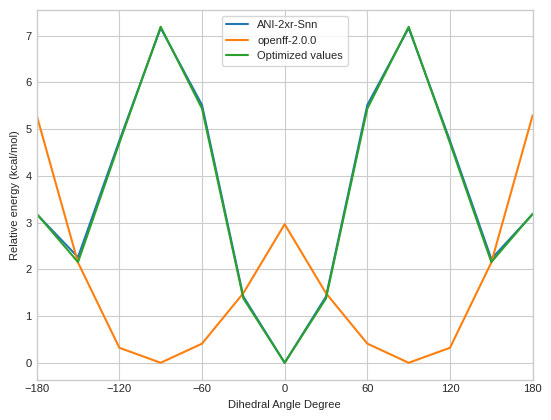

In [11]:
#@title **Visualize the Optimized Dihedral Profile**

#@markdown The optimized parameters printed in the previous cell are those that should be added to your force field to correctly parametrize the selected dihedral.

#@markdown Please select the number of Fourier terms (periodic functions) you want to include in your topology definition.

PK_IDIVF1 = fitted_coefficients_list[0]
PK_IDIVF2 = fitted_coefficients_list[1:3]
PK_IDIVF3 = fitted_coefficients_list[3:6]
PK_IDIVF4 = fitted_coefficients_list[6:10]
PK_IDIVF5 = fitted_coefficients_list[10:15]
PK_IDIVF6 = fitted_coefficients_list[15:21]

PHASE1 = phase_offset_list[0]
PHASE2 = phase_offset_list[1:3]
PHASE3 = phase_offset_list[3:6]
PHASE4 = phase_offset_list[6:10]
PHASE5 = phase_offset_list[10:15]
PHASE6 = phase_offset_list[15:21]

PN1 = multiplicity_list[0]
PN2 = multiplicity_list[1:3]
PN3 = multiplicity_list[3:6]
PN4 = multiplicity_list[6:10]
PN5 = multiplicity_list[10:15]
PN6 = multiplicity_list[15:21]

functions = "4" #@param ["1", "2", "3", "4", "5", "6"]

mm_file = f"{Force_field}_{atom1}_{atom2}_{atom3}_{atom4}.dat"
mm = list(map(float, open(mm_file).read().split()))
angles = range(min_deg, (max_deg + int(degrees_steps)), int(degrees_steps))
values = []

if functions == "1":
    dict_params = {1: [PK_IDIVF1, PHASE1, PN1]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL1 = PK_IDIVF1 * (1 + math.cos(math.radians(PN1 * ANGLE - PHASE1)))
        values.append(EDIHEDRAL1 + mm[i])

elif functions == "2":
    dict_params = {1: [PK_IDIVF2[0], PHASE2[0], PN2[0]], 2: [PK_IDIVF2[1], PHASE2[1], PN2[1]]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL1 = PK_IDIVF2[0] * (1 + math.cos(math.radians(PN2[0] * ANGLE - PHASE2[0])))
        EDIHEDRAL2 = PK_IDIVF2[1] * (1 + math.cos(math.radians(PN2[1] * ANGLE - PHASE2[1])))
        values.append(EDIHEDRAL1 + EDIHEDRAL2 + mm[i])

elif functions == "3":
    dict_params = {1: [PK_IDIVF3[0], PHASE3[0], PN3[0]], 2: [PK_IDIVF3[1], PHASE3[1], PN3[1]], 3: [PK_IDIVF3[2], PHASE3[2], PN3[2]]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL1 = PK_IDIVF3[0] * (1 + math.cos(math.radians(PN3[0] * ANGLE - PHASE3[0])))
        EDIHEDRAL2 = PK_IDIVF3[1] * (1 + math.cos(math.radians(PN3[1] * ANGLE - PHASE3[1])))
        EDIHEDRAL3 = PK_IDIVF3[2] * (1 + math.cos(math.radians(PN3[2] * ANGLE - PHASE3[2])))
        values.append(EDIHEDRAL1 + EDIHEDRAL2 + EDIHEDRAL3 + mm[i])

elif functions == "4":
    dict_params = {1: [PK_IDIVF4[0], PHASE4[0], PN4[0]], 2: [PK_IDIVF4[1], PHASE4[1], PN4[1]], 3: [PK_IDIVF4[2], PHASE4[2], PN4[2]], 4: [PK_IDIVF4[3], PHASE4[3], PN4[3]]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL1 = PK_IDIVF4[0] * (1 + math.cos(math.radians(PN4[0] * ANGLE - PHASE4[0])))
        EDIHEDRAL2 = PK_IDIVF4[1] * (1 + math.cos(math.radians(PN4[1] * ANGLE - PHASE4[1])))
        EDIHEDRAL3 = PK_IDIVF4[2] * (1 + math.cos(math.radians(PN4[2] * ANGLE - PHASE4[2])))
        EDIHEDRAL4 = PK_IDIVF4[3] * (1 + math.cos(math.radians(PN4[3] * ANGLE - PHASE4[3])))
        values.append(EDIHEDRAL1 + EDIHEDRAL2 + EDIHEDRAL3 + EDIHEDRAL4 + mm[i])

elif functions == "5":
    dict_params = {1: [PK_IDIVF5[0], PHASE5[0], PN5[0]], 2: [PK_IDIVF5[1], PHASE5[1], PN5[1]], 3: [PK_IDIVF5[2], PHASE5[2], PN5[2]], 4: [PK_IDIVF5[3], PHASE5[3], PN5[3]], 5: [PK_IDIVF5[4], PHASE5[4], PN5[4]]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL1 = PK_IDIVF5[0] * (1 + math.cos(math.radians(PN5[0] * ANGLE - PHASE5[0])))
        EDIHEDRAL2 = PK_IDIVF5[1] * (1 + math.cos(math.radians(PN5[1] * ANGLE - PHASE5[1])))
        EDIHEDRAL3 = PK_IDIVF5[2] * (1 + math.cos(math.radians(PN5[2] * ANGLE - PHASE5[2])))
        EDIHEDRAL4 = PK_IDIVF5[3] * (1 + math.cos(math.radians(PN5[3] * ANGLE - PHASE5[3])))
        EDIHEDRAL5 = PK_IDIVF5[4] * (1 + math.cos(math.radians(PN5[4] * ANGLE - PHASE5[4])))
        values.append(EDIHEDRAL1 + EDIHEDRAL2 + EDIHEDRAL3 + EDIHEDRAL4 + EDIHEDRAL5 + mm[i])

elif functions == "6":
    dict_params = {1: [PK_IDIVF6[0], PHASE6[0], PN6[0]], 2: [PK_IDIVF6[1], PHASE6[1], PN6[1]], 3: [PK_IDIVF6[2], PHASE6[2], PN6[2]], 4: [PK_IDIVF6[3], PHASE6[3], PN6[3]], 5: [PK_IDIVF6[4], PHASE6[4], PN6[4]], 6: [PK_IDIVF6[5], PHASE6[5], PN6[5]]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL1 = PK_IDIVF6[0] * (1 + math.cos(math.radians(PN6[0] * ANGLE - PHASE6[0])))
        EDIHEDRAL2 = PK_IDIVF6[1] * (1 + math.cos(math.radians(PN6[1] * ANGLE - PHASE6[1])))
        EDIHEDRAL3 = PK_IDIVF6[2] * (1 + math.cos(math.radians(PN6[2] * ANGLE - PHASE6[2])))
        EDIHEDRAL4 = PK_IDIVF6[3] * (1 + math.cos(math.radians(PN6[3] * ANGLE - PHASE6[3])))
        EDIHEDRAL5 = PK_IDIVF6[4] * (1 + math.cos(math.radians(PN6[4] * ANGLE - PHASE6[4])))
        EDIHEDRAL6 = PK_IDIVF6[5] * (1 + math.cos(math.radians(PN6[5] * ANGLE - PHASE6[5])))
        values.append(EDIHEDRAL1 + EDIHEDRAL2 + EDIHEDRAL3 + EDIHEDRAL4 + EDIHEDRAL5 + EDIHEDRAL6 + mm[i])

values = np.array(values)
values = values - min(values)

#Plot ANI, MM and the new dihedral potential
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
plt.plot(dihe_degree, ref_energies, linewidth = 1.5, label = model_name)
plt.plot(dihe_degree, energy_diff, linewidth = 1.5, label = Force_field)
plt.plot(dihe_degree, values, linewidth = 1.5, label = "Optimized values")
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([min_deg, max_deg])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
png_name = f"{model_name}_{Force_field}_fit_{atom1}_{atom2}_{atom3}_{atom4}.png"
plt.savefig(png_name, dpi=600, bbox_inches='tight')

In [12]:
#@title **OpenMM Minimization with Optimized Dihedral Parameters**

#@markdown This step performs energy minimization using the newly optimized dihedral potential for the selected torsion.

#@markdown Force constant to restrain the dihedral angle:

Force_constant = 1000 #@param {type:"slider", min:100, max:2000, step:100}


#@markdown Convergence threshold for minimization energy:

opt_tol = 0.001 #@param {type:"slider", min:0.001, max:0.1, step:0.001}

from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
from simtk.openmm.app import PDBFile
import parmed
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
# import pytraj as pt
import xml.etree.ElementTree as ET
xml = openmm.XmlSerializer.serialize(system)
root = ET.fromstring(xml)

from sys import stdout, exit, stderr
import os, math, fnmatch

workDir2 = "/content/"

if os.path.exists(os.path.join(workDir2, "potential_energy_new.txt")):
  os.remove(os.path.join(workDir2,"potential_energy_new.txt"))
else:
  pass

# Create an OpenFF Molecule object for benzene from sdf
from openff.toolkit.topology import Molecule
molecule = Molecule.from_smiles(Smiles)
# molecule = Molecule.from_file("/content/mol_files/0_min.mol")

# Create an OpenMM ForceField object with AMBER ff14SB and TIP3P with compatible ions
from simtk.openmm.app import ForceField
forcefield = ForceField('amber99sb.xml')

# Register the  template generator
forcefield.registerTemplateGenerator(type_generator_options.generator)

potential_energy = []
dihe_degree = []
for deg in range(min_deg, (max_deg+int(degrees_steps)), int(degrees_steps)):
  pdbfile = PDBFile(os.path.join(workDir, "mol_files/" + str(deg) + "_min.pdb"))

  if sequencially_parametrization == "yes":
    with open(os.path.join(workDir, 'system_openMM.xml')) as input:
        system = XmlSerializer.deserialize(input.read())
    # topology = pdbfile.getTopology()
  else:
    system = forcefield.createSystem(pdbfile.topology, nonbondedCutoff=1*nanometer, constraints=HBonds)


  energy_expression = "k*(1-cos(periodicity*theta-theta0))"
  custom_torsion_force = CustomTorsionForce(energy_expression)
  custom_torsion_force.addGlobalParameter("k", int(Force_constant))
  custom_torsion_force.addGlobalParameter("periodicity", 1)
  custom_torsion_force.addGlobalParameter("theta0", math.radians(deg))
  custom_torsion_force.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4))
  system.addForce(custom_torsion_force)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  count = 0
  for k,v in dict_params.items():
    PK_IDIVF, PHASE, PN = v
    dih.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4), PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
    count += 1

  integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
  simulation = Simulation(pdbfile.topology, system, integrator)
  simulation.context.setPositions(pdbfile.positions)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  for i in range(dih.getNumTorsions()):
    particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)
    if particle2 == int(atom2) and particle3 == int(atom3):
      dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
      dih.updateParametersInContext(simulation.context)
    elif particle2 == int(atom3) and particle3 == int(atom2):
      dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
      dih.updateParametersInContext(simulation.context)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  a = (dih.getNumTorsions() - 1) - count
  b = 0
  for k,v in dict_params.items():
    PK_IDIVF, PHASE, PN = v
    b += 1
    dih.setTorsionParameters(a+b, particle1, particle2, particle3, particle4, PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
    dih.updateParametersInContext(simulation.context)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  for i in range(dih.getNumTorsions()):
    particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)

  simulation.minimizeEnergy(tolerance=float(opt_tol)*kilojoule/(mole*nanometer), maxIterations=int(1000000))
  minpositions = simulation.context.getState(getPositions=True).getPositions()
  app.PDBFile.writeFile(pdbfile.topology, minpositions, open(os.path.join(workDir2, "pdb_min/" + str(deg) + '_min_new.pdb'), 'w'))

  energy_kcal =  (simulation.context.getState(getEnergy=True).getPotentialEnergy())
  potential_energy.append(energy_kcal)
  dihe_degree.append(deg)
  for i, f in enumerate(system.getForces()):
    state = simulation.context.getState(getEnergy=True, groups={i})
    # print(f.getName(), state.getPotentialEnergy())

  # print(str(deg) + " =", str(energy_kcal))
  print("Running minimization for step:" + str(deg))
  print(str(energy_kcal), file=open("potential_energy_new.txt", "a",))

#Prepare the relative energy from MM with new dihedral potential
import pandas as pd
dataset = pd.read_csv('/content/potential_energy_new.txt', delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df[df.columns[:1]]
new = df.to_numpy()
energy_new = (np.array(new) - min(new)) * 0.239006

print("Degrees    Energy")
energy_mm_new = np.round(energy_new, 4)
a_file = open(f"{Force_field}_new_{atom1}_{atom2}_{atom3}_{atom4}.dat", "w")
for deg, row in zip(dihe_degree, energy_new):
    degree_str = str("{:.3f}".format(deg))
    energy_new_str = str("{:.3f}".format(row[0]))
    string = degree_str.rjust(8, " ") + energy_new_str.rjust(8, " ") + " kcal/mol"
    print(string)
    np.savetxt(a_file, row, fmt='%.6f')
a_file.close()

# Create the Open Forcefield Topology.
local_dir = "/content"

topology = pdbfile.topology

if sequencially_parametrization == "yes":
  with open(os.path.join(workDir, 'system_openMM.xml')) as input:
      omm_system = XmlSerializer.deserialize(input.read())
else:
  omm_system = forcefield.createSystem(pdbfile.topology)

integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)

dih = [f for f in omm_system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
count = 0
for k,v in dict_params.items():
  PK_IDIVF, PHASE, PN = v
  dih.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4), PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
  count = count + 1

simulation = Simulation(pdbfile.topology, omm_system, integrator)
simulation.context.setPositions(pdbfile.positions)

dih = [f for f in omm_system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
for i in range(dih.getNumTorsions()):
  particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)
  if particle2 == int(atom2) and particle3 == int(atom3):
    dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
    dih.updateParametersInContext(simulation.context)
  elif particle2 == int(atom3) and particle3 == int(atom2):
    dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
    dih.updateParametersInContext(simulation.context)

dih = [f for f in omm_system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
a = (dih.getNumTorsions() - 1) - count
b = 0
for k,v in dict_params.items():
  PK_IDIVF, PHASE, PN = v
  b = b + 1
  dih.setTorsionParameters(a+b, particle1, particle2, particle3, particle4, PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
  dih.updateParametersInContext(simulation.context)

# Convert OpenMM System to a ParmEd structure.
parmed_structure = parmed.openmm.load_topology(pdbfile.topology, omm_system, pdbfile.positions)

# Save the ParmEd structure to a PDB file ad xml.
paths_openmm = {
    "top_openmm": os.path.join(local_dir, "system_openMM.xml"),
    "pdb_openmm": os.path.join(local_dir, "system_openMM.pdb"),

}

parmed_structure.save(paths_openmm["pdb_openmm"], overwrite=True)
with open(paths_openmm["top_openmm"], 'w') as output:
  output.write(XmlSerializer.serialize(omm_system))


Running minimization for step:-180
Running minimization for step:-150
Running minimization for step:-120
Running minimization for step:-90
Running minimization for step:-60
Running minimization for step:-30
Running minimization for step:0
Running minimization for step:30
Running minimization for step:60
Running minimization for step:90
Running minimization for step:120
Running minimization for step:150
Running minimization for step:180
Degrees    Energy
-180.000   3.194 kcal/mol
-150.000   2.201 kcal/mol
-120.000   4.622 kcal/mol
 -90.000   7.185 kcal/mol
 -60.000   5.332 kcal/mol
 -30.000   1.307 kcal/mol
   0.000   0.000 kcal/mol
  30.000   1.307 kcal/mol
  60.000   5.331 kcal/mol
  90.000   7.185 kcal/mol
 120.000   4.622 kcal/mol
 150.000   2.201 kcal/mol
 180.000   3.195 kcal/mol


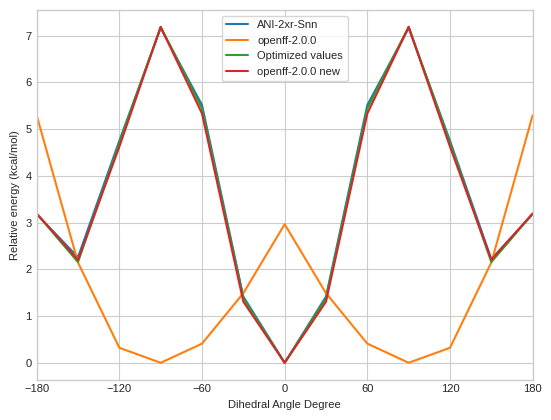

In [13]:
#@title **Visualize the Energy Profile with Optimized Dihedral Parameters (OpenMM)**

#@markdown This plot displays the energy profile calculated using OpenMM with the newly optimized dihedral parameters.

#@markdown The **y-axis** shows the **relative energy** in *kcal/mol*, and the **x-axis** represents the dihedral angle in degrees.

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

plt.plot(dihe_degree, ref_energies, linewidth = 1.5, label = model_name)
plt.plot(dihe_degree, energy_diff, linewidth = 1.5, label = Force_field)
plt.plot(dihe_degree, values, linewidth = 1.5, label = "Optimized values")
plt.plot(dihe_degree, energy_new, linewidth = 1.5, label = str(Force_field) + " new")
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([min_deg, max_deg])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
png_name = f"{model_name}_{Force_field}_fit_new_{atom1}_{atom2}_{atom3}_{atom4}.png"
plt.savefig(png_name, dpi=600, bbox_inches='tight')

In [ ]:
#@title **Building an download the new topology**:

#@markdown Select the program of your choice:

from openff.toolkit.topology import Molecule, Topology
import parmed
import zipfile
from google.colab import files
import locale
local_dir = "/content"

program = "GROMACS" #@param ["GROMACS", "OpenMM"]

if program == "GROMACS":

  paths_gromacs = {
      "top_gromacs": os.path.join(local_dir, "system_gromacs.top"),
      "gro_gromacs": os.path.join(local_dir, "system_gromacs.gro"),
      "pdb_gromacs": os.path.join(local_dir, "system_gromacs.pdb"),

  }

  parmed_structure.save(paths_gromacs["top_gromacs"], overwrite=True)
  parmed_structure.save(paths_gromacs["gro_gromacs"], overwrite=True)
  parmed_structure.save(paths_gromacs["pdb_gromacs"], overwrite=True)
  gromacs_top = os.path.exists(paths_gromacs["top_gromacs"])
  gromacs_gro = os.path.exists(paths_gromacs["gro_gromacs"])
  gromacs_pdb = os.path.exists(paths_gromacs["pdb_gromacs"])

  if gromacs_top == True and gromacs_gro == True and gromacs_pdb == True:

      # Define the name of the zip file
      zip_file_name = "gromacs.zip"

      # Create the zip file and add files
      with zipfile.ZipFile(zip_file_name, 'w') as zipf:  # Open in append mode
          existing_files = zipf.namelist()  # Get a list of existing files in the zip

          # Add topology files
          for file_key, file_path in paths_gromacs.items():
              file_name = os.path.basename(file_path)
              if os.path.exists(file_path) and f"topology/{file_name}" not in existing_files:  # Check if the file exists and not already in the zip
                  zipf.write(file_path, arcname=f"topology/{file_name}")

          for png_file in glob.glob(os.path.join( "*.png")):
              file_name = os.path.basename(png_file)
              if f"images/{file_name}" not in existing_files:  # Check if the file is not already in the zip
                  zipf.write(png_file, arcname=f"images/{file_name}")

          for dat_file in glob.glob(os.path.join( "*.dat")):
              file_name = os.path.basename(dat_file)
              if f"raw_files/{file_name}" not in existing_files:  # Check if the file is not already in the zip
                  zipf.write(dat_file, arcname=f"raw_files/{file_name}")

          for mol_file in glob.glob(os.path.join( "mol_files/*.mol")):
              file_name = os.path.basename(mol_file)
              if f"mol_files/{file_name}" not in existing_files:  # Check if the file is not already in the zip
                  zipf.write(mol_file, arcname=f"mol_files/{file_name}")

          for pdb_file in glob.glob(os.path.join( "mol_files/*.pdb")):
              file_name = os.path.basename(pdb_file)
              if f"mol_files/{file_name}" not in existing_files:  # Check if the file is not already in the zip
                  zipf.write(pdb_file, arcname=f"pdb_files/{file_name}")

      files.download('gromacs.zip')
      print("Successfully generated topology! :-)")
  else:
      print("ERROR: Check your inputs! ")

elif program == "OpenMM":

  openmm_pdb = os.path.exists(paths_openmm["pdb_openmm"])
  openmm_xml = os.path.exists(paths_openmm["top_openmm"])
  if openmm_pdb == True and openmm_xml == True:
      # Define the name of the zip file
      zip_file_name = "openmm.zip"

      # Create the zip file and add files
      with zipfile.ZipFile(zip_file_name, 'w') as zipf:  # Open in append mode
          existing_files = zipf.namelist()  # Get a list of existing files in the zip

          # Add topology files
          for file_key, file_path in paths_openmm.items():
              file_name = os.path.basename(file_path)
              if os.path.exists(file_path) and f"topology/{file_name}" not in existing_files:  # Check if the file exists and not already in the zip
                  zipf.write(file_path, arcname=f"topology/{file_name}")

          for png_file in glob.glob(os.path.join( "*.png")):
              file_name = os.path.basename(png_file)
              if f"images/{file_name}" not in existing_files:  # Check if the file is not already in the zip
                  zipf.write(png_file, arcname=f"images/{file_name}")

          for dat_file in glob.glob(os.path.join( "*.dat")):
              file_name = os.path.basename(dat_file)
              if f"raw_files/{file_name}" not in existing_files:  # Check if the file is not already in the zip
                  zipf.write(dat_file, arcname=f"raw_files/{file_name}")

          for mol_file in glob.glob(os.path.join( "mol_files/*.mol")):
              file_name = os.path.basename(mol_file)
              if f"mol_files/{file_name}" not in existing_files:  # Check if the file is not already in the zip
                  zipf.write(mol_file, arcname=f"mol_files/{file_name}")

          for pdb_file in glob.glob(os.path.join( "mol_files/*.pdb")):
              file_name = os.path.basename(pdb_file)
              if f"mol_files/{file_name}" not in existing_files:  # Check if the file is not already in the zip
                  zipf.write(pdb_file, arcname=f"pdb_files/{file_name}")

      files.download('openmm.zip')

      print("Successfully generated topology! :-)")
  else:
      print("ERROR: Check your inputs! ")

else:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully generated topology! :-)
